# Fractal in Logistics System

In the notebook _Fractal in Biology_, we tested the emergence of fractal from mammalian vessel system. But, the fractal is absent under the assumptions by West, et al. (1997). In this notebook, we try to update the assumptions to make them more plausible. Instead of mammalian vessel system, we consider a much simpler case: the logistic system of a city.

## Notations

- $C$: number of levels.
- $k$: level, from $0$ to $C$.
- $n_k$: number of logistics sites at $k$ level.
- $l_k$: logistics scale at $k$ level.
- $f_k$: flow rate at $k$ level.
- $\nu_k$: $n_{k+1} / n_k$.
- $\lambda_k$: $l_{k+1} / l_k$.
- $\phi_k$: $f_{k+1} / f_{k}$.

## Assumptions

Assumptions are made as follow. For details, see [this blog](https://shuiruge.github.io/2024/03/01/complex-system/) (TODO: explain the details here).

The $f_C$ and $l_C$ are fixed. Naturally, $n_0 = 1$. Thus,

$$ l_k = \frac{l_k}{l_{k+1}} \cdots \frac{l_{C-1}}{l_C} l_C = l_C \lambda_k^{-1} \cdots \lambda_{C-1}^{-1} = l_C \prod_{i=k}^{C-1} \lambda_i^{-1}. $$

The same,

$$ f_k = f_C \prod_{i=k}^{C-1} \phi_i^{-1}, $$

but,

$$ n_k = n_0 \frac{n_1}{n_0} \cdots \frac{n_k}{n_{k-1}} = \nu_0 \cdots \nu_{k-1} = \prod_{i=0}^{k-1} \nu_i. $$

The perserving of flow rate implies

$$ f_k = \nu_k^{-1}. $$

And the space-fulfilling assumption implies

$$ \lambda_k = \nu_k^{-1/2}. $$

Because of these, the unique degree of freedom is the $\nu$.

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import logsumexp
import matplotlib.pyplot as plt

We use several samples in searching optimal parallelly. So, the $\nu$, or for numerical stability $\ln \nu$, has tensor shape `[samples, levels]`.

In [2]:
LEVELS = 5

## Loss Function

The objective to be minimized is the total consumption logistics. It is

$$ F := \sum_{k=0}^C n_{k} f_{k} l_{k} = f_C l_C \sum_{k=0}^C \prod_{i=0}^{k-1} \nu_i \prod_{i=k}^{C-1} (\phi_i \lambda_i)^{-1}. $$

Plugging the relation between $\nu$ and $\phi$ and $\lambda$, we find

$$ F = f_C l_C \sum_{k=0}^C \prod_{i=0}^{k-1} \nu_i \prod_{i=k}^{C-1} \nu_i^{3/2}. $$

For numerical stability, we consider

$$ \ln F = \ln (f_C l_C) + \ln \sum_{k=0}^C \prod_{i=0}^{k-1} \nu_i \prod_{i=k}^{C-1} \nu_i^{3/2}. $$

In [3]:
def get_log_consumption(log_nu):
    """Omit the constant."""
    logits = np.stack([
        np.sum(log_nu[:k]) + (3/2) * np.sum(log_nu[k:])
        for k in range(LEVELS+1)
    ])
    return logsumexp(logits)

log_nu = np.log(2) * np.ones([1, LEVELS])
get_log_consumption(log_nu)

5.8319391794405995

The population of the city is proportional to $n_C = \prod_{k=0}^{C-1} \nu_k$. To investigate the relation between total consumption of logistics and the population of the city, the population shall be fixed.

In [4]:
def get_log_population(log_nu):
    return np.sum(log_nu)

get_log_population(log_nu)

3.4657359027997265

Since $n_{k+1} \ge n_k$, $\nu_k$ shall be greater than unit. So, there is another constraint that, for each $k$,

$$ \ln \nu_k \ge 0. $$

Altogether, the loss function shall be

$$ \ln F(\nu) + \mu \left( \ln n_C(\nu) - \ln \bar{n}_C \right) + \sum_{k=1}^{C-1} \omega_k \left( \ln \nu_k - z_k^2 \right), $$

for some observed values $\bar{n}_C$ given.

What is a proper value of $\bar{n}_C$. It is natural to suppose that $n_{k+1}/n_k \ge 2$. This means $\bar{n}_C$ shall be greater than the volume given by $\nu = 2$. And it shall not be too large, for numerical consideration.

In fact, it is sufficient for the optimized volume to approximate the order of $\bar{n}_C$. We can regard this optimized volume as the real $\bar{n}_C$. In other words, $\bar{n}_C$ is used to determine the order, but not the accurate value.

In [5]:
least_log_population = get_log_population(np.log(2) * np.ones([LEVELS]))
least_log_population

3.4657359027997265

In [6]:
TRUE_LOG_POPULATION = 5e+2

## Optimization

In [7]:
initial_values = [np.random.uniform(3., 5.) for _ in range(LEVELS)]
bounds = [(0., None) for _ in range(LEVELS)]
constraints = [
    {
        'type': 'eq',
        'fun': lambda log_nu: get_log_population(log_nu) - TRUE_LOG_POPULATION,
    },
]
result = minimize(
    get_log_consumption,
    initial_values,
    bounds=bounds,
    constraints=constraints,
    tol=1e-50,
    options={'maxiter': 1000},
)
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 750.0
       x: [ 9.901e+01  1.004e+02  1.007e+02  1.003e+02  9.964e+01]
     nit: 3
     jac: [ 1.500e+00  1.500e+00  1.500e+00  1.500e+00  1.500e+00]
    nfev: 12
    njev: 2

In [8]:
optimized_log_nu = result.x

Let us check the optimization results:

In [9]:
get_log_consumption(optimized_log_nu), get_log_population(optimized_log_nu)

(750.0, 500.0)

And for checking fractal:

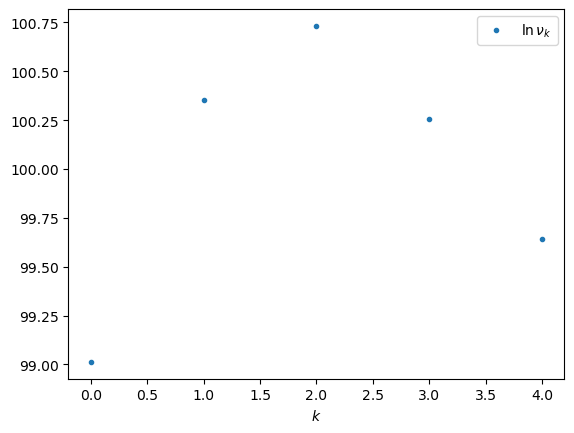

In [10]:
plt.plot(optimized_log_nu, '.', label='$\\ln \\nu_k$')
# plt.plot(np.exp(optimized_log_nu), '.', label='$\\nu_k$')
plt.xlabel('$k$')
plt.legend()
plt.show()

Fractal emerges, since the $\ln \nu_k$ are approximately equal for $k > 0$.